<a href="https://colab.research.google.com/github/tejseth/nfl-tutorials-2022/blob/master/nfl_data_py_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modeling with NFL Data in Python


#### Installing Packages 

In [139]:
# !pip install nfl_data_py
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install sklearn
# !pip install xgboost

#### Loading in Packages

In [140]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier

#### Loading in Play-by-Play Data

In [91]:
pbp = nfl.import_pbp_data([2020, 2021, 2022])

2020 done.
2021 done.
2022 done.
Downcasting floats.


In [92]:
pbp.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,1.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,None,None,None,...,None,None,NaN,None,NaN,,,,0.0,0.0
1,39.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,None,None,NaN,None,NaN,45142;46331;46674;45037;46253;44878;42579;4637...,00-0033258;00-0034490;00-0033862;00-0029747;00...,00-0034073;00-0034730;00-0033783;00-0031961;00...,11.0,11.0
2,54.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",4.0,40078;46078;45069;46113;38551;45185;42718;4781...,00-0029892;00-0034847;00-0033221;00-0034860;00...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0
3,93.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",NaN,40078;46078;45069;46113;38551;45185;42718;4781...,00-0029892;00-0034847;00-0033221;00-0034860;00...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0
4,118.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,SINGLEBACK,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",NaN,40078;46078;46113;45069;38551;45185;42718;4781...,00-0029892;00-0034847;00-0034860;00-0033221;00...,00-0029585;00-0035236;00-0031557;00-0029747;00...,11.0,11.0


#### Getting Dataset Ready for Modeling

In [99]:
print(pbp.shape)
pbp_clean = pbp[(pbp['pass'] == 1) & (pbp['play_type'] != "no_play")]
print(pbp_clean.shape)

(149195, 384)
(64339, 384)


#### Doing some EDA

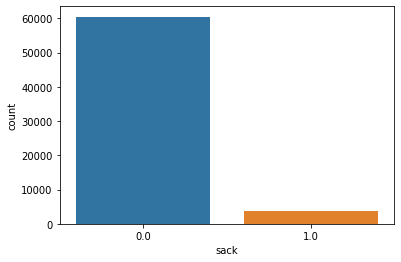

In [112]:
sns.countplot(x=pbp_clean["sack"])
plt.show()

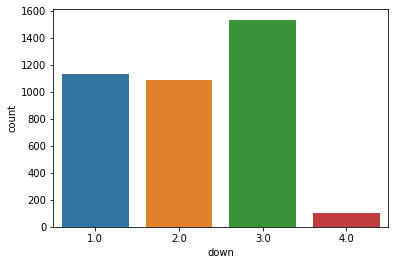

In [100]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["down"])
plt.show()

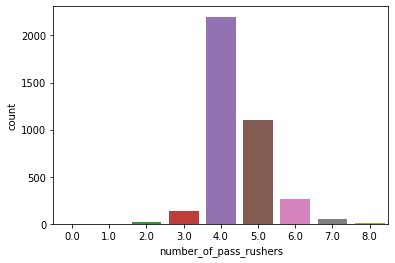

In [103]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["number_of_pass_rushers"])
plt.show()

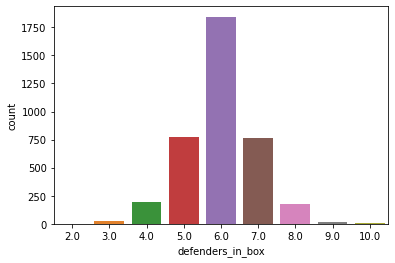

In [105]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["defenders_in_box"])
plt.show()

#### Feature Engineering

In [102]:
pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)

<ipython-input-102-aefebe19c44f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)


In [114]:
pre_df = pbp_clean[['game_id', 'play_id', 'name', 'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining',
                    'defenders_in_box', 'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack']]
df = pre_df.dropna()
df.isna().sum()

game_id                   0
play_id                   0
name                      0
down                      0
ydstogo                   0
yardline_100              0
game_seconds_remaining    0
defenders_in_box          0
number_of_pass_rushers    0
xpass                     0
obvious_pass              0
sack                      0
dtype: int64

In [115]:
df.head()

,game_id,play_id,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack
2,2020_01_ARI_SF,54.0,J.Garoppolo,1.0,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0
6,2020_01_ARI_SF,165.0,J.Garoppolo,3.0,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0
9,2020_01_ARI_SF,245.0,K.Murray,1.0,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0
10,2020_01_ARI_SF,274.0,K.Murray,2.0,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0
11,2020_01_ARI_SF,298.0,K.Murray,1.0,10.0,65.0,3360.0,6.0,4.0,0.453060,0,0.0


#### Modeling

In [125]:
df['down'] = df['down'].astype('category')
df_no_ids = df.drop(columns = ['game_id', 'play_id', 'name'])
df_no_ids = pd.get_dummies(df_no_ids, columns = ['down'])

<ipython-input-125-dc1b936e74bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['down'] = df['down'].astype('category')


In [126]:
df_no_ids.columns

Index(['ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
       'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack', 'down_1.0',
       'down_2.0', 'down_3.0', 'down_4.0'],
      dtype='object')

In [127]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(df_no_ids, df_no_ids['sack']):
    strat_train_set = df_no_ids.iloc[train_index]
    strat_test_set = df_no_ids.iloc[test_index]

X_train = strat_train_set.drop(columns = ['sack'])
Y_train = strat_train_set['sack']
X_test = strat_test_set.drop(columns = ['sack'])
Y_test = strat_test_set['sack']

In [137]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)

LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, LR_pred))

Brier Score:  0.058958630116350455


In [138]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

RF_pred = pd.DataFrame(RF.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, RF_pred))

Brier Score:  0.06218318155879537


In [141]:
XGB = XGBClassifier(objective="binary:logistic", random_state=42)
XGB.fit(X_train, Y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, XGB_pred))

Brier Score:  0.058118945589371154


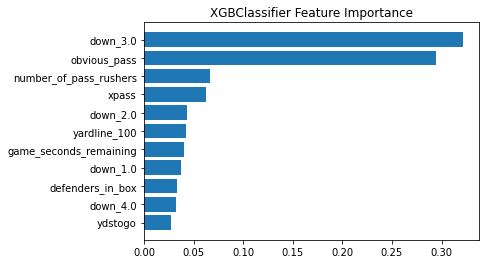

In [143]:
sorted_idx = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.title("XGBClassifier Feature Importance")
plt.show()

In [149]:
make_sacks_preds = df_no_ids.drop('sack', axis = 1)
XGB_total_predictions = pd.DataFrame(XGB.predict_proba(make_sacks_preds), columns = ['no_sack', 'sack_pred'])[['sack_pred']]

sacks_preds = df.copy()
sacks_preds['sack_pred'] = XGB_total_predictions

sacks_preds['sacks_oe'] = sacks_preds['sack'] - sacks_preds['sack_pred']
sacks_preds[(sacks_preds['season'] == 2022)].groupby('name').agg({'sack': 'sum', 'sack_pred': 'sum', 'sacks_oe': 'sum'}).reset_index().sort_values('sacks_oe', ascending = True).head(10)

KeyError: ignored